In [1]:
# load data
# clean data
# features extraction
# model
# predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Code.toolbox import compare_freq
# from Code.Tutorial.denoise_fft import fft_denoise


In [3]:
def get_noise(signal, peaks, distance=8):
    margin = peaks[0]
    mask = np.ones(signal.shape)
    mask_added = np.zeros(signal.shape)
    for i in range(len(peaks)):
        peak = peaks[i]
        if i == len(peaks) - 1:
            peak_next = 1000
        else:
            peak_next = peaks[i + 1] - margin
        if i % 2 == 1:
            dis = distance * 2
        else:
            dis = distance
        mask[peak - margin: peak + dis] = 0
        mask_added[peak - margin: peak + dis] = np.mean(signal[peak + dis: peak_next])
    return signal * mask + mask_added


from scipy.signal import find_peaks
from scipy.interpolate import interp1d


def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a


def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [4]:
def standize_1d(signal):
    return (signal - signal.mean()) / signal.std()
def standize_2d(signal):
    return (signal - signal.mean(1, keepdims=True)) / signal.std(1, keepdims=True)

In [5]:
from Code.Tutorial.Dataset import load_scg

def load_(path):
    data = np.load(path)
    signals, labels = data[:, :1000], data[:, 1000:]
    return signals, labels


In [6]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)

    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([ m_12/m_21, mag_0/mag_1])

    return features

In [7]:
def fft_denoise(signal, threshold):
    """
    Applies FFT-based denoising to a signal.

    Parameters:
    signal (array-like): Input signal to be denoised.
    threshold (float): Threshold for filtering out noise.

    Returns:
    array-like: Denoised signal after applying FFT-based denoising.
    """

    num_samples = len(signal)  # Length of the input signal
    fhat = np.fft.fft(signal)  # Compute the FFT of the signal
    psd = fhat * np.conjugate(fhat) / num_samples  # Compute the power spectral density
    threshold = np.max(psd) * 0.13
    indices = psd > threshold  # Identify indices above the threshold for filtering
    fhat = indices * fhat  # Apply filtering to the FFT coefficients
    ffilt = np.fft.ifft(fhat)  # Compute the inverse FFT
    ffilt = ffilt.real  # Take the real part of the inverse FFT

    return ffilt

In [8]:
def segmentation(signal, rpeak, h, d, S, D):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    template = np.median(pieces_padded, 0)

    # template_peaks_ = get_peaks(template, distance, duration, fs)
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks_, template[template_peaks_])
        plt.show()
        return None



    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]
    plt.figure()
    plt.plot(template)
    plt.scatter(template_peaks_, template[template_peaks_])
    plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}, S:{S}, D:{D}')
    plt.show()

    return [dis12/dis21, A0/A1]

In [9]:
def wiener(noisy_signal, hr, show=False):
    peaks = get_peaks(noisy_signal, 2000 // (hr+2), 10, 100)

    sep_noise = get_noise(noisy_signal, peaks)
    signal = noisy_signal - sep_noise

    signal = np.nan_to_num(signal)
    sep_noise = np.nan_to_num(sep_noise)

    signal_power = np.abs(np.fft.fft(signal))**2
    noise_power = np.abs(np.fft.fft(sep_noise))**2
    noise_power = np.mean(noise_power)
    snr = signal_power / noise_power

    wiener_filter = 1 / (1 + 1 / snr)
    filtered_signal = np.fft.fft(noisy_signal) * wiener_filter
    filtered_signal = np.fft.ifft(filtered_signal)

    if show:
        compare_freq(noisy_signal, filtered_signal)
        plt.figure()
        plt.plot(noisy_signal)
        plt.plot(filtered_signal)
        filtered_peaks = get_peaks(noisy_signal, 2000 // (hr+2), 10, 100)
        plt.scatter(filtered_peaks, filtered_signal[filtered_peaks], color='r')
        plt.show()

    return np.real(filtered_signal)

# if __name__=='__main__':
#
#     signals_n_0_train, labels_n_0_train = load_('../../Data/Normal/sim_5000_0_90_140_train_normal.npy')
#     signals_n_0_test, labels_n_0_test = load_('../../Data/Normal/sim_3000_0_141_178_test_normal.npy')
#
#
#     signals_n_0_train = standize_2d(signals_n_0_train)
#     signals_n_x_train = signals_n_0_train + np.random.normal(loc=0.0, scale=0.8, size=signals_n_0_train.shape)
#
#     signals_n_0_test = standize_2d(signals_n_0_test)
#     signals_n_x_test = signals_n_0_test + np.random.normal(loc=0.0, scale=0.8, size=signals_n_0_test.shape)
#
#
#     def extract(signals, labels, dis):
#         features = []
#         idxs = []
#         for cnt, signal in enumerate(signals):
#             hr = labels[cnt, 2]
#             filtered_signal = wiener(signal, hr, False)
#             try:
#                 peaks = get_peaks(filtered_signal, 2000 // (hr+2), 10, 100)
#                 if len(peaks) < 14:
#                     continue
#                 feature = get_features(filtered_signal, peaks)
#                 features.append(feature)
#                 idxs.append(cnt)
#             except(Exception):
#                 print(cnt)
#         return np.array(features), np.array(idxs)
#
#     features_train, idxs_train = extract(signals_n_x_train, labels_n_0_train, 15)
#     features_test, idxs_test = extract(signals_n_x_test, labels_n_0_test, 10)



In [44]:

if __name__=='__main__':

    signals_n_0_train, labels_n_0_train = load_('../../Data/Normal/sim_5000_0_90_140_train_normal.npy')
    signals_n_0_test, labels_n_0_test = load_('../../Data/Normal/sim_3000_0_141_178_test_normal.npy')

    signals_n_0_train_ls = []
    labels_n_0_train_ls = []
    for cnt, signal in enumerate(signals_n_0_train):
        if max(signal) > 1:
            continue
        signals_n_0_train_ls.append(signal)
        labels_n_0_train_ls.append(labels_n_0_train[cnt])


    signals_n_0_test_ls = []
    labels_n_0_test_ls = []
    for cnt, signal in enumerate(signals_n_0_test):
        if max(signal) > 1:
            continue
        signals_n_0_test_ls.append(signal)
        labels_n_0_test_ls.append(labels_n_0_test[cnt])

    signals_n_0_train = np.array(signals_n_0_train_ls)
    signals_n_0_test = np.array(signals_n_0_test_ls)
    labels_n_0_train = np.array(labels_n_0_train_ls)
    labels_n_0_test = np.array(labels_n_0_test_ls)

    print(signals_n_0_train.shape, signals_n_0_test.shape)

    signals_n_x_train = signals_n_0_train + np.random.normal(loc=0.0, scale=1, size=signals_n_0_train.shape) * 1e-6
    signals_n_x_test = signals_n_0_test + np.random.normal(loc=0.0, scale=1, size=signals_n_0_test.shape) * 1e-6


    def extract(signals, labels, clean_signals, aplha):
        features = []
        idxs = []
        for cnt, signal in enumerate(signals):
            hr = labels[cnt, 2]
            # wiener_signal = wiener(signal, hr, False)
            wiener_signal = signal
            fft_wiener_signal = fft_denoise(wiener_signal, 2)
            # large_peaks, _ = find_peaks(fft_wiener_signal, height=np.max(fft_wiener_signal) * 0.5, distance=30)
            #
            # plt.figure()
            # plt.plot(signal)
            # plt.plot(fft_wiener_signal)
            # plt.scatter(large_peaks, fft_wiener_signal[large_peaks])
            # plt.show()
            # peaks = get_peaks(fft_wiener_signal, 15, 10, 100)
            peaks, _ = find_peaks(fft_wiener_signal, height=np.max(fft_wiener_signal) * 0.12, distance=2000 // (hr * aplha))
            peaks = update_array(peaks, fft_wiener_signal / np.max(fft_wiener_signal))
            if len(peaks) % 2 != 0:
                peaks = np.delete(peaks, len(peaks) - 1)

            # try:
            feature = get_features(fft_wiener_signal, peaks)
            features.append(feature)
            # except(Exception):

            # if cnt % 61 == 0:
            #     plt.figure()
            #     plt.plot(clean_signals[cnt])
            #     plt.plot(fft_wiener_signal)
            #     plt.scatter(peaks, fft_wiener_signal[peaks])
            #     plt.title(f'S:{labels[cnt, 4]} f:{feature[0]}')
            #     plt.show()

            # template_feature = segmentation(fft_wiener_signal, large_peaks, h, d, labels[cnt, 4], labels[cnt, 5])
            # if template_feature is not None:
            #
            #     template_features.append(template_feature)

            # if cnt > 1000:
            #     break
        return np.array(features), np.array(idxs)

    features_train, idxs_train = extract(signals_n_x_train, labels_n_0_train,signals_n_0_train, 1)
    features_test, idxs_test = extract(signals_n_x_test, labels_n_0_test, signals_n_0_test, 1.2)


(4687, 1000) (2853, 1000)


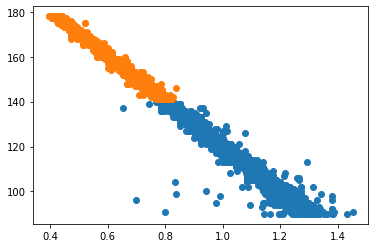

1.3414022636630392
Saved plot to ././pic/Manually_Normal_S_10.jpg


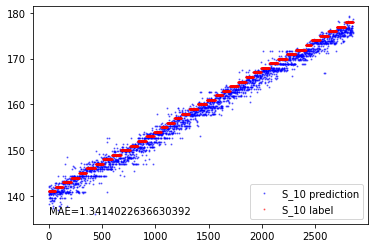

In [45]:
    plt.figure()
    plt.scatter(np.array(features_train)[:, 0], labels_n_0_train[:, 4])
    plt.scatter(np.array(features_test)[:, 0], labels_n_0_test[:, 4])
    plt.show()

    from sklearn.linear_model import LinearRegression as LR

    reg = LR().fit(np.array(features_train)[:, 0].reshape(-1, 1), labels_n_0_train[:, 4])
    yhat = reg.predict(np.array(features_test)[:, 0].reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_n_0_test[:, 4])))

    from Code.Tutorial.utils import plot_2vectors

    plot_2vectors( labels_n_0_test[:, 4], yhat, True, 'S_10', '././pic/Manually_Normal_S_10')


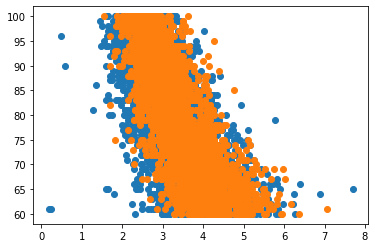

6.555546302538188
Saved plot to ./pic/Manually_Normal_D_10.jpg


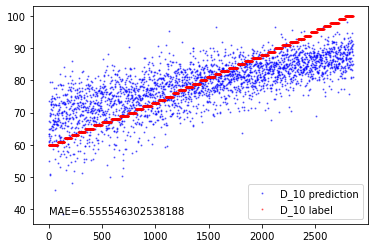

In [46]:
    plt.figure()
    plt.scatter(np.array(features_train)[:, 1], labels_n_0_train[:, 5])
    plt.scatter(np.array(features_test)[:, 1], labels_n_0_test[:, 5])
    plt.show()

    # from sklearn.linear_model import LinearRegression as LR

    reg = LR().fit(np.nan_to_num(np.array(features_train)[:, 1]).reshape(-1, 1), np.nan_to_num(labels_n_0_train[:, 5]))
    yhat = reg.predict(np.nan_to_num(np.array(features_test[:, 1])).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_n_0_test[:, 5])))

    from Code.Tutorial.utils import plot_2vectors

    plot_2vectors( labels_n_0_test[:, 5], yhat,  True, 'D_10', './pic/Manually_Normal_D_10')


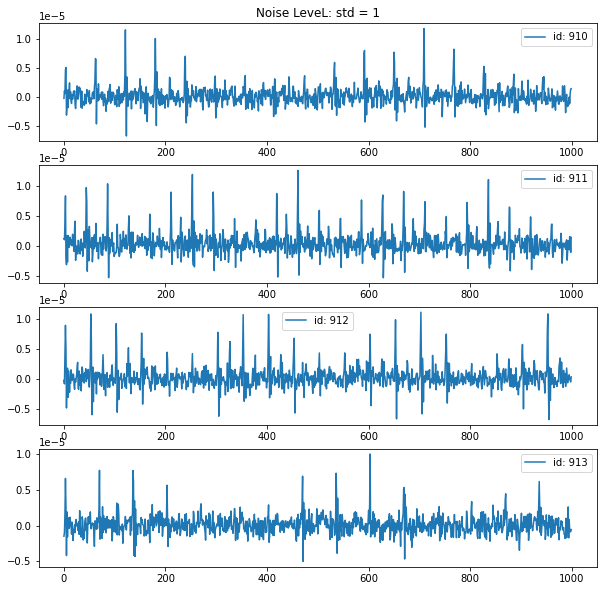

In [52]:
plt.subplots(4, 1, figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(signals_n_x_train[910], label='id: 910')
plt.legend()
plt.title('Noise LeveL: std = 1')
plt.subplot(4, 1, 2)
plt.plot(signals_n_x_train[911], label='id: 911')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(signals_n_x_train[912], label='id: 912')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(signals_n_x_train[913], label='id: 913')
plt.legend()
plt.savefig('./Normal_Noise_Manually.jpg',dpi=300)